# GPT 3.5 for Boosting the Performance of Large Language Models for Question Answering with Knowledge Graph Integration
by Mingze Li

In this file, we need to first process the fine-tuning dataset, then fine-tune the model and finally process the QA tasks with a given dataset contains quesions and contexts.

In [1]:
import tiktoken # for token counting
import numpy as np
import json
from collections import defaultdict

### Load the dataset contains quesions and contexts
If you have some new datasets please reload them here.
Note: the number of questions must not less than the number of context

In [2]:
import pandas as pd
path = r"C:\Users\Li\Desktop\train_8_without score.xlsx" #r"C:\Users\Li\Desktop\input.xlsx"
df = pd.read_excel(path)
df

,Competency Question,Ground Truth,Related Triples,Context,Predicted Answer
0,Who is working in the Computational Materials ...,PD Dr. habil. Thomas Hammerschmidt; Prof. Dr. ...,[('http://demo.fiz-karlsruhe.de/matwerk/E12452...,"Pyiron YouTube channel has description ""Welcom...",Prof. Dr.-Ing. Stephan Wulfinghoff is working ...
1,What are the research projects associated to E...,VIMMP (2018-2021); OYSTER (2017-2021); SimDOME...,[('http://demo.fiz-karlsruhe.de/matwerk/E11267...,Elemental Multiperspective Material Ontology (...,The research projects associated with EMMO can...
2,"Who are the contributors of the data ""datasets""?",Prof. Felix Fritzen <http://demo.fiz-karlsruhe...,[('http://demo.fiz-karlsruhe.de/matwerk/E10428...,Materials Data Repository has contributor Nati...,"The contributors of the data ""datasets"" could ..."
3,"Who is working with Researcher ""Ebrahim Norouz...",Prof. Dr. Harald Sack; Mirza Mohtashim Alam; D...,[('http://demo.fiz-karlsruhe.de/matwerk/E15879...,Ebrahim Norouzi has work package FIZ Karlsruhe...,"I'm sorry, but I couldn't find any specific in..."
4,"who is the email address of ""ParaView""?",support@kitware.com,"[('https://schema.org/dateCreated', 'rdfs:comm...","dateCreated has comment ""The date on which the...","I'm sorry, I cannot provide an email address f..."
5,What are the affilliations of Volker Hofmann?,Forschungszentrum Jülich <http://demo.fiz-karl...,[('http://demo.fiz-karlsruhe.de/matwerk/E14531...,Dr. Tilmann Hickel has affiliation with Max-Pl...,The affiliation of Dr. Volker Hofmann is the F...
6,"What is ""Molecular Dynamics"" Software? List th...",1. Resource: http://demo.fiz-karlsruhe.de/matw...,[('http://demo.fiz-karlsruhe.de/matwerk/E55172...,"OpenBIS has description ""The openBIS platform...",Molecular Dynamics software are simulation pac...
7,What are pre- and post-processing tools for MD...,Pizza.py Toolkit; pyscal; ASE; MDTraj; freud,[('http://demo.fiz-karlsruhe.de/matwerk/E46999...,Graphical Interface for Materials Simulations ...,Pre- and post-processing tools for MD (molecul...
8,What are some workflow environments for comput...,Pyiron; AiiDA; SimStack,[('http://demo.fiz-karlsruhe.de/matwerk/E49750...,"matminer has description ""Python library for ...",Some common workflow environments for computat...
9,How should I cite pyiron?,"""title = {pyiron: An integrated development en...",[('http://demo.fiz-karlsruhe.de/matwerk/E12466...,APT analysis using CompositionSpace and pyiron...,You can cite Pyiron using the following inform...


In [3]:
questions = df['Competency Question']
contexts = df['Context']
length = questions.count()
print(questions.count())
print(contexts.count())


38
35


## QA tasks based on the baseline model

In [4]:
import os
from openai import OpenAI
import openai

def get_answer_with_single_question(question, context):

    # Set OpenAI API key
    api_key = os.environ.get('OPENAI_API_KEY')
    openai.api_key = api_key

    # Initialize OpenAI client
    client = OpenAI(api_key=api_key)

    # Set up the model
    model= 'gpt-3.5-turbo-1106'

    try:
        messages=[
                    {"role": "system", "content": "You are a helpful assistant. You are a helpful assistant. Extract and answer using key information from context. Ensure the response is concise, without duplicates, focusing solely on crucial details. There are two examples: Example 1: (Context: The sun is a star in the center of our solar system.Question: What is the sun? Answer: A star at the center of the solar system.) and Example 2: (Context: Neil Armstrong was the first person to walk on the moon. Question: Who was the first person to walk on the moon? Answer: Neil Armstrong.). Your answer must be provided in a direct and concise format, without using any lead-in phrases such as 'Answer:' or similar. Only the answer itself should be included in the response.  "},
                    # instruction
                    {"role": "user", "content": "Context: " + context + " Question:" + question}
        ]
        response = client.chat.completions.create(
            model=model,
            messages=messages
        )
        
        # Extract and return the answer
        answer = response.choices[0].message.content
        return answer

    except Exception as e:
        print(f"An error occurred while processing the problem: {e}")
        return "Unable to get answer"


In [5]:
from openai import OpenAI
import openai
import os


# Set OpenAI API key
api_key = os.environ.get('OPENAI_API_KEY')
openai.api_key = api_key

# Initialize OpenAI client
client = OpenAI(api_key=api_key)

# Set up the model
model = 'gpt-3.5-turbo-1106'

user_input_count = 0
arr_answers = []

for i in range(length):
    if contexts[i] == "":
        user_input_count += 1
        continue
    print(f"No. {user_input_count} question: {questions[i]}")
    print(f"No. {user_input_count} context: {contexts[i]}")
    answer = get_answer_with_single_question(questions[i], contexts[i])
    arr_answers.append(answer)
    print(f"No. {user_input_count} answer: {answer}")
    user_input_count += 1

No. 0 question: Who is working in the Computational Materials Science field?
No. 0 context: Pyiron YouTube channel has description "Welcome to our youtube channel where we present pyiron - an integrated development environment for computational materials science. "; MaterialsMine (MM) has description "A materials ontology to support data publication involving nanomaterials and metamaterials."; Materials Design Ontology (MDO) has related Project Open Databases Integration for Materials Design (OPTIMADE); Materials Design Ontology (MDO) has documentation w3id.org/mdo/full/1.0/; Materials Design Ontology (MDO) has description "MDO is an ontology for materials design field, representing the domain knowledge specifically related to solid-state physics and computational materials science."; Open Materials Database has description "The Open Materials Database is a publicly available, searchable database for information on the properties of materials created by people who work in computational

In [6]:
arr_answers

['Prof. Dr. Karsten Durst, Prof. Dr.-Ing. Stephan Wulfinghoff, Christian Dorn, Dr.-Ing Abril Azocar Guzman, Prof. Dr. Jörg Neugebauer, Stefan Diebels, PD Dr. Franz Roters, PD Dr. habil. Thomas Hammerschmidt, Dr Sarath Menon are working in the Computational Materials Science field.',
 'Project EMMC-CSA (2016-2019), SimDOME (2019-2023), MarketPlace (2018-2022), VIMMP (2018-2021), OntoTrans (2020-2024), ReaxPro (2019-2023), OntoCommons (2020-2023), OYSTER (2017-2021), NanoMECommons (2021-2025), OpenModel (2021-2025).',
 'Fernández, Prof. Felix Fritzen, Oliver Weeger, and Frederik Larsson.',
 'Mirza Mohtashim Alam.',
 'support@kitware.com',
 'Max-Planck-Institut für Eisenforschung GmbH',
 'GROMACS is "Molecular Dynamics" Software. It is programmed in C, C++, and Fortran. It is described in the citations listed and published under the GNU Lesser General Public License (LGPL) version 2.1.',
 'freud, MDTraj, OVITO basic, and Pizza.py Toolkit',
 'matminer, Simmate, Polymer Genome, Atomistictoo

In [7]:
df['answer_text'] = arr_answers
df

,Competency Question,Ground Truth,Related Triples,Context,Predicted Answer,answer_text
0,Who is working in the Computational Materials ...,PD Dr. habil. Thomas Hammerschmidt; Prof. Dr. ...,[('http://demo.fiz-karlsruhe.de/matwerk/E12452...,"Pyiron YouTube channel has description ""Welcom...",Prof. Dr.-Ing. Stephan Wulfinghoff is working ...,"Prof. Dr. Karsten Durst, Prof. Dr.-Ing. Stepha..."
1,What are the research projects associated to E...,VIMMP (2018-2021); OYSTER (2017-2021); SimDOME...,[('http://demo.fiz-karlsruhe.de/matwerk/E11267...,Elemental Multiperspective Material Ontology (...,The research projects associated with EMMO can...,"Project EMMC-CSA (2016-2019), SimDOME (2019-20..."
2,"Who are the contributors of the data ""datasets""?",Prof. Felix Fritzen <http://demo.fiz-karlsruhe...,[('http://demo.fiz-karlsruhe.de/matwerk/E10428...,Materials Data Repository has contributor Nati...,"The contributors of the data ""datasets"" could ...","Fernández, Prof. Felix Fritzen, Oliver Weeger,..."
3,"Who is working with Researcher ""Ebrahim Norouz...",Prof. Dr. Harald Sack; Mirza Mohtashim Alam; D...,[('http://demo.fiz-karlsruhe.de/matwerk/E15879...,Ebrahim Norouzi has work package FIZ Karlsruhe...,"I'm sorry, but I couldn't find any specific in...",Mirza Mohtashim Alam.
4,"who is the email address of ""ParaView""?",support@kitware.com,"[('https://schema.org/dateCreated', 'rdfs:comm...","dateCreated has comment ""The date on which the...","I'm sorry, I cannot provide an email address f...",support@kitware.com
5,What are the affilliations of Volker Hofmann?,Forschungszentrum Jülich <http://demo.fiz-karl...,[('http://demo.fiz-karlsruhe.de/matwerk/E14531...,Dr. Tilmann Hickel has affiliation with Max-Pl...,The affiliation of Dr. Volker Hofmann is the F...,Max-Planck-Institut für Eisenforschung GmbH
6,"What is ""Molecular Dynamics"" Software? List th...",1. Resource: http://demo.fiz-karlsruhe.de/matw...,[('http://demo.fiz-karlsruhe.de/matwerk/E55172...,"OpenBIS has description ""The openBIS platform...",Molecular Dynamics software are simulation pac...,"GROMACS is ""Molecular Dynamics"" Software. It i..."
7,What are pre- and post-processing tools for MD...,Pizza.py Toolkit; pyscal; ASE; MDTraj; freud,[('http://demo.fiz-karlsruhe.de/matwerk/E46999...,Graphical Interface for Materials Simulations ...,Pre- and post-processing tools for MD (molecul...,"freud, MDTraj, OVITO basic, and Pizza.py Toolkit"
8,What are some workflow environments for comput...,Pyiron; AiiDA; SimStack,[('http://demo.fiz-karlsruhe.de/matwerk/E49750...,"matminer has description ""Python library for ...",Some common workflow environments for computat...,"matminer, Simmate, Polymer Genome, Atomisticto..."
9,How should I cite pyiron?,"""title = {pyiron: An integrated development en...",[('http://demo.fiz-karlsruhe.de/matwerk/E12466...,APT analysis using CompositionSpace and pyiron...,You can cite Pyiron using the following inform...,{pyiron: An integrated development environment...


## Dataframe saved as a XLSX file

In [8]:
save_path = r"C:\Users\Li\Desktop\results_baseline_GPT3.5_without_finetuning_with_context.xlsx"

df.to_excel(save_path, index=False)

print("successfully saved", save_path)

successfully saved C:\Users\Li\Desktop\results_baseline_GPT3.5_without_finetuning_with_context.xlsx


# Evaluation
by Haoran Yang

In [14]:
import pandas as pd
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu
from sentence_transformers import SentenceTransformer, util

# Define paths
excel_file_path = save_path
output_file_path = r'C:\Users\Li\Desktop\result_with_score_baseline.xlsx'

# Read Excel file
df = pd.read_excel(excel_file_path, usecols=['Competency Question', 'Context', 'Ground Truth', 'answer_text'])

# Initialize scorers
rouge = Rouge()
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Prepare a dictionary to store scores
scores_dict = {
    "ROUGE-1-f": [], "ROUGE-1-p": [], "ROUGE-1-r": [],
    "ROUGE-2-f": [], "ROUGE-2-p": [], "ROUGE-2-r": [],
    "ROUGE-L-f": [], "ROUGE-L-p": [], "ROUGE-L-r": [],
    "BLEU": [],
    "SBERT-Similarity": []
}

# Calculate scores
for _, row in df.iterrows():
    ground_truth = str(row['Ground Truth']) if not pd.isnull(row['Ground Truth']) else ""
    predicted_answer = str(row['answer_text']) if not pd.isnull(row['answer_text']) else ""
    
    # Calculate ROUGE scores
    if ground_truth and predicted_answer:
        rouge_scores = rouge.get_scores(predicted_answer, ground_truth)[0]
        for key in scores_dict:
            if key.startswith("ROUGE"):
                rouge_type, rouge_metric = key.split('-')[1], key.split('-')[2]
                scores_dict[key].append(rouge_scores['rouge-{}'.format(rouge_type.lower())][rouge_metric])
    else:
        for key in scores_dict:
            if key.startswith("ROUGE"):
                scores_dict[key].append(None)
    
    # Calculate BLEU score
    reference = ground_truth.split()
    candidate = predicted_answer.split()
    bleu_score = sentence_bleu([reference], candidate, weights=(0.25, 0.25, 0.25, 0.25)) if ground_truth and predicted_answer else None
    scores_dict["BLEU"].append(bleu_score)
    
    # Calculate SBERT-Similarity score
    if ground_truth and predicted_answer:
        embeddings1 = sbert_model.encode([ground_truth], convert_to_tensor=True)
        embeddings2 = sbert_model.encode([predicted_answer], convert_to_tensor=True)
        cos_sim = util.pytorch_cos_sim(embeddings1, embeddings2)
        scores_dict["SBERT-Similarity"].append(cos_sim.item())
    else:
        scores_dict["SBERT-Similarity"].append(None)

# Add scores to DataFrame
for key, value in scores_dict.items():
    df[key] = value

# Save to Excel file
df.to_excel(output_file_path, index=False)

print(f"Scores have been calculated and the results are saved to: {output_file_path}")


c:\users\li\pycharmprojects\pythonproject\venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\users\li\pycharmprojects\pythonproject\venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\users\li\pycharmprojects\pythonproject\venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Con

Scores have been calculated and the results are saved to: C:\Users\Li\Desktop\result_with_score_baseline.xlsx


0     0.535714
1     0.526316
2     0.434783
3     0.285714
4     1.000000
5     0.000000
6     0.147368
7     0.266667
8     0.000000
9     0.509434
10    0.142857
11    0.153846
12         NaN
13    0.066667
14    0.181818
15    0.208333
16    0.000000
17    0.000000
18    0.000000
19    0.000000
20    0.000000
21    0.000000
22    1.000000
23    0.058252
24    0.000000
25    0.072727
26    0.000000
27    0.052632
28    1.000000
29    0.727273
30    0.000000
31    1.000000
32    0.000000
33    1.000000
34    0.000000
35    0.571429
36    0.000000
37         NaN
Name: ROUGE-1-f, dtype: float64


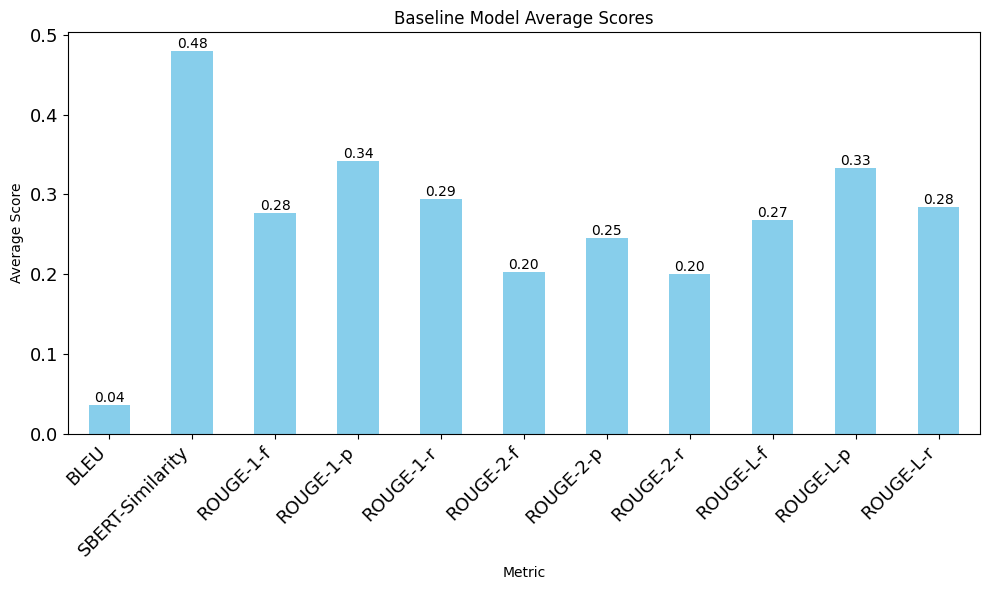

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load Excel file

output_file_path = output_file_path
df = pd.read_excel(output_file_path)
print(df['ROUGE-1-f'])
# Specify columns to compute mean
columns_to_mean = [
    'BLEU', 'SBERT-Similarity',
    'ROUGE-1-f', 'ROUGE-1-p', 'ROUGE-1-r',
    'ROUGE-2-f', 'ROUGE-2-p', 'ROUGE-2-r',
    'ROUGE-L-f', 'ROUGE-L-p', 'ROUGE-L-r'
]

# Compute mean
means = df[columns_to_mean].mean()

# Visualization
ax = means.plot(kind='bar', figsize=(10, 6), color='skyblue', fontsize=13)

plt.title('Baseline Model Average Scores')
plt.xlabel('Metric')
plt.ylabel('Average Score')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding

# Add values above each bar
for i in ax.patches:
    ax.text(i.get_x() + i.get_width() / 2, i.get_height(), f'{i.get_height():.2f}', ha='center', va='bottom')

plt.show()
